### NLP exploration of Find it Fix It requests to the City of Seattle (from a FOI request)

In [7]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from collections import Counter

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.text import Text
from nltk.probability import FreqDist

from wordcloud import WordCloud

import gensim
from gensim import corpora


In [2]:
#path for FIFI FOI request data (already prepped for NLP)
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/generated_datasets/data_final_nlp.pkl'

In [3]:
#read in pkl file containing 
data = pd.read_pickle(path)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)
data = data[data['FIFI_category'] != 'Community Walk']
print(data.shape)
data.head(1)

(221839, 70)


,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,zip,neighborhood,SittingInformal,Lying,DisruptiveActivity_Aggressive,DisruptiveActivity_Intoxicated,LivingActivities,Soliciting,overdose,pop,pop_dens,housing_units,med_home,land_area,occupied_units,occupied_ratio,med_income,med_age,male_%,white_%,fam_%,nokid_%,mortgage_%,fulltime_%,unemploy,drive_%,publictrans_%,other_%,wrk_travel,city council,county council,polarity,desc_nltk,POS
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"[ford, light, blue]","[(ford, NN), (light, NN), (blue, NN)]"


In [4]:
#only use data that has complete year
print(data.shape)
data = data[data['FIFI_category'] != 'Community Walk']
print(data.shape)
data = data[data['neighborhood'] != 'DT?']
print(data.shape)
#data_complete = data[data['year'].isin([2014, 2015, 2016, 2017, 2018])]
#print(data_complete.shape)
data_complete_seattle = data[~data['city council'].isna()]
print(data_complete_seattle.shape)
data_complete_seattle_other = data_complete_seattle[data_complete_seattle['FIFI_category'] == 'Other']
print(data_complete_seattle_other.shape)

(221839, 70)
(221839, 70)
(221834, 70)
(191329, 70)
(42527, 70)


### Unsupervised sentiment analysis

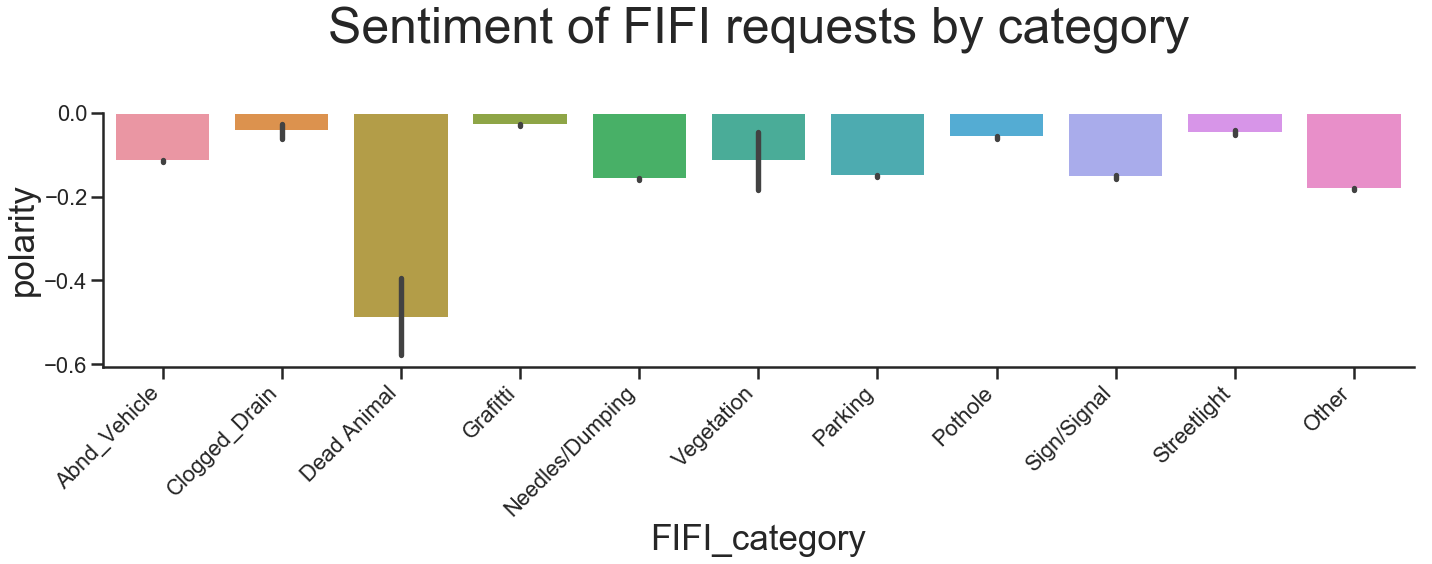

In [5]:
#how does sentiment change across FIFI category?
g = sns.catplot(x='FIFI_category', y='polarity', data=data_complete_seattle, kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by category', y=1.25)
plt.subplots_adjust(hspace = 1.5)

In [10]:
data[data['polarity'] == data['polarity'].max()]['Description']

215687    THANK YOU!!! for fixing this light!  It is terrific!! And really does the job.   I hope you can refer to this feedback that we, at Horizon House are VERY happy and appreciative of you following through and getting this one done. Thanks also for fixing the light across the street which seemed like a more straight forward repair or bulb replacement. But this light apparently need a whole new, different style fixture with which I am very pleased!  Many thanks to everyone one involved to get this done!!!\nJohn Daniels, 206-679-0382.  Feel free to use my name about the success of "Find It, Fix It.  Thank You.
Name: Description, dtype: object

In [11]:
data[data['polarity'] == data['polarity'].min()]['Description']

164220    The referenced refers to curbside parking permissible between 3-6 pm M-F. On Rainier Ave S & S Kenyon to S Rose Street. I commute Rainier Ave S every day for the past ten years. There is no such other dangerous traffic flow obstacle as this. Rainier ave S has become horrendous for traffic volume and especially road rage. This small strip of permissible parking chokes off south bound commute traffic at a critical time and location. When people realize the are a couple cars ahead blocking the already congested lanes the rage to swerve left into the other lane is terrifying and very dangerous. Then once past the two block obstacle the rage is to get back into the right lane and get ahead of everyone. And of course in both instances commuters are resisting the lane change even though the car on the right is head straight for a collision with a parked car. Those who park on this narrow strip routinely disregard the time restrictions. And when outside the time restriction routinely

In [30]:
data[data['polarity'] > 0.95].groupby(['FIFI_category'])['FIFI_category'].count().reset_index(name='count: polarity > 0.95')

,FIFI_category,count: polarity > 0.95
0,Grafitti,2
1,Needles/Dumping,5
2,Other,22
3,Pothole,3
4,Sign/Signal,3
5,Streetlight,4


In [29]:
data[data['polarity'] < -0.95].groupby(['FIFI_category'])['FIFI_category'].count().reset_index(name='count: polarity < -0.95')

,FIFI_category,count: polarity < -0.95
0,Abnd_Vehicle,6
1,Needles/Dumping,31
2,Other,83
3,Parking,257
4,Pothole,4
5,Sign/Signal,7
6,Streetlight,1


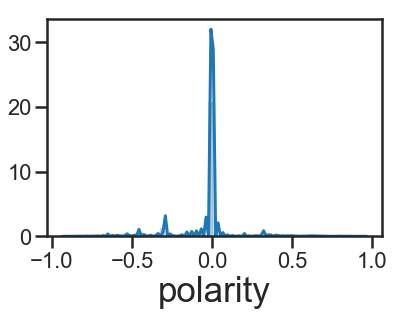

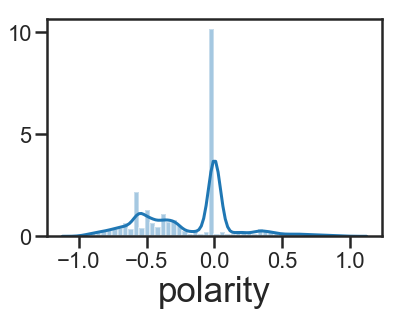

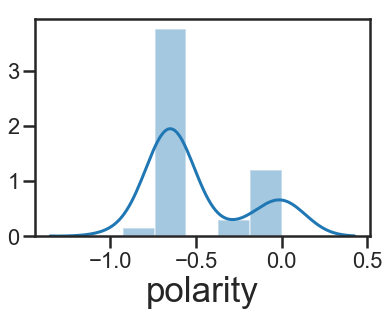

In [64]:
#what does the distribution look like across categories?
sns.distplot(data_complete_seattle[data_complete_seattle['FIFI_category'] == 'Grafitti']['polarity'])
plt.show()
sns.distplot(data_complete_seattle[data_complete_seattle['FIFI_category'] == 'Other']['polarity'])
plt.show()
sns.distplot(data_complete_seattle[data_complete_seattle['FIFI_category'] == 'Dead Animal']['polarity'])
plt.show()

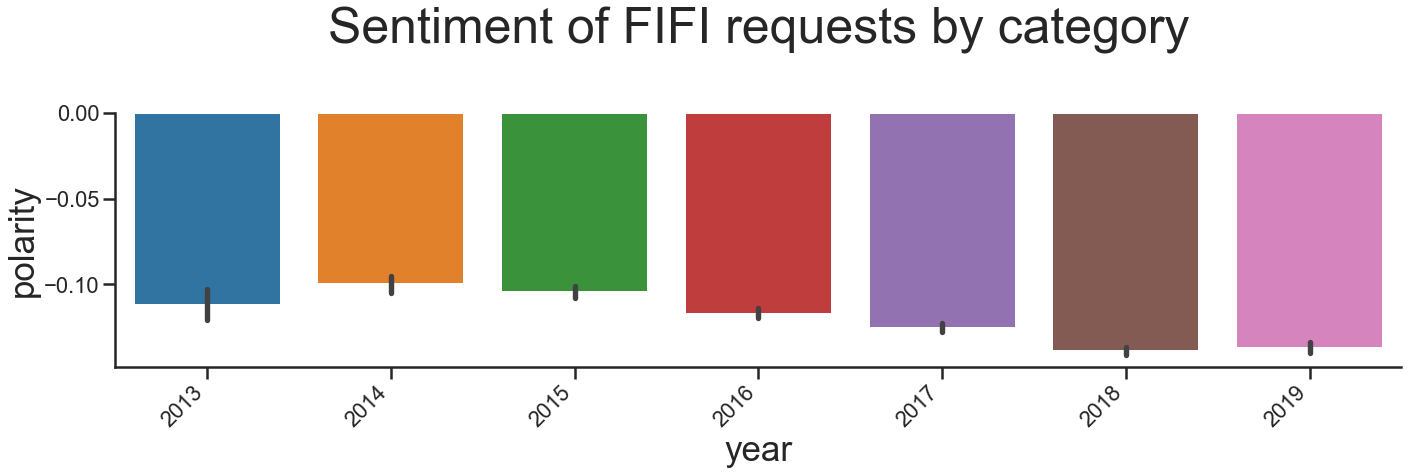

In [9]:
#how does sentiment change across year?
g = sns.catplot(x='year', y='polarity', data=data, kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by category', y=1.25)
plt.subplots_adjust(hspace = 1.5)

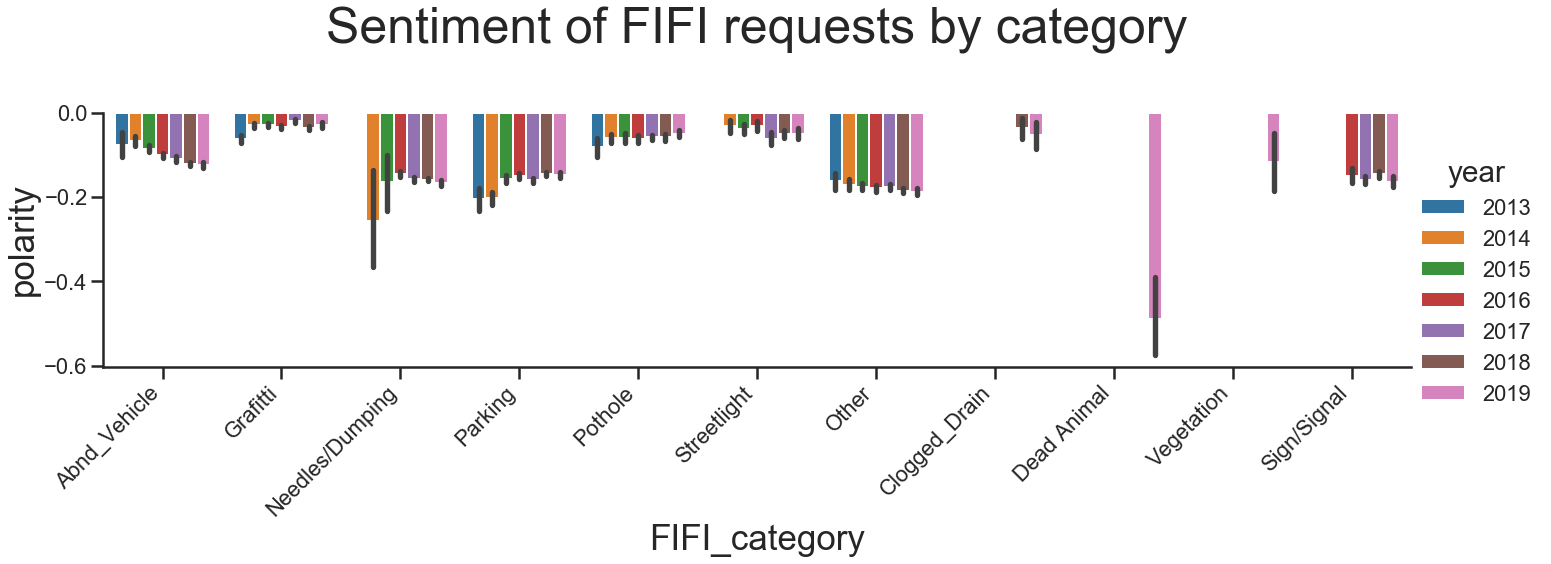

In [32]:
#how does sentiment change across category and year?
g = sns.catplot(x='FIFI_category', y='polarity', data=data, kind='bar', hue='year', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by category', y=1.25)
plt.subplots_adjust(hspace = 1.5)

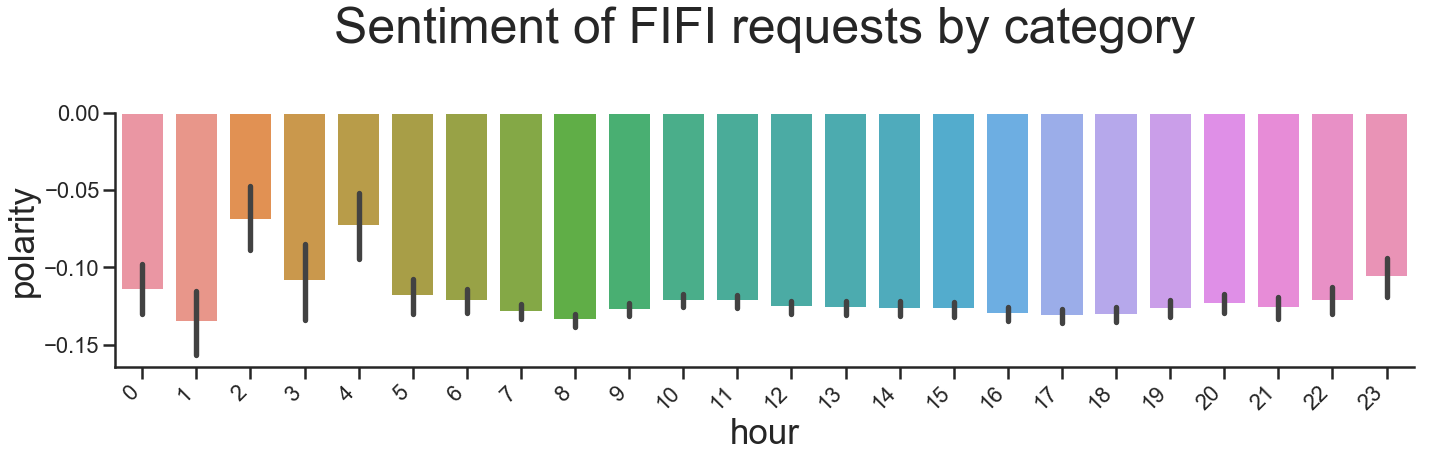

In [33]:
#how does sentiment change across time?
g = sns.catplot(x='hour', y='polarity', data=data, kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by category', y=1.25)
plt.subplots_adjust(hspace = 1.5)

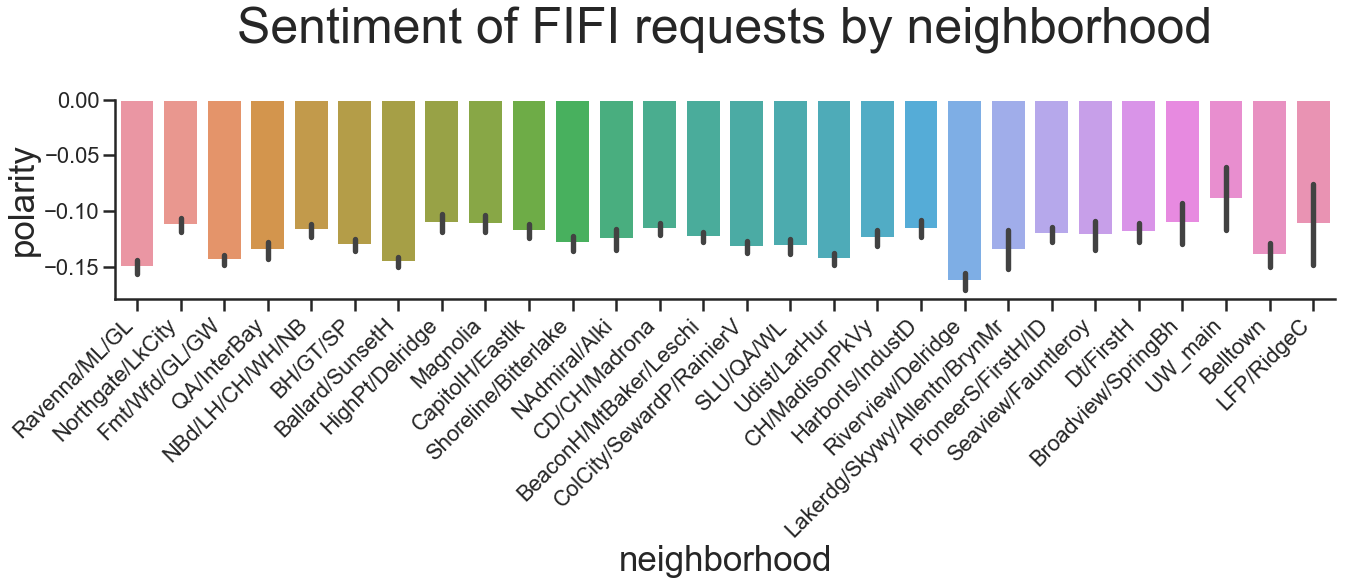

In [86]:
#how does sentiment change across neighborhoods?
g = sns.catplot(x='neighborhood', y='polarity', data=data_complete_seattle, kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by neighborhood', y=1.25)
plt.subplots_adjust(hspace = 1.5)

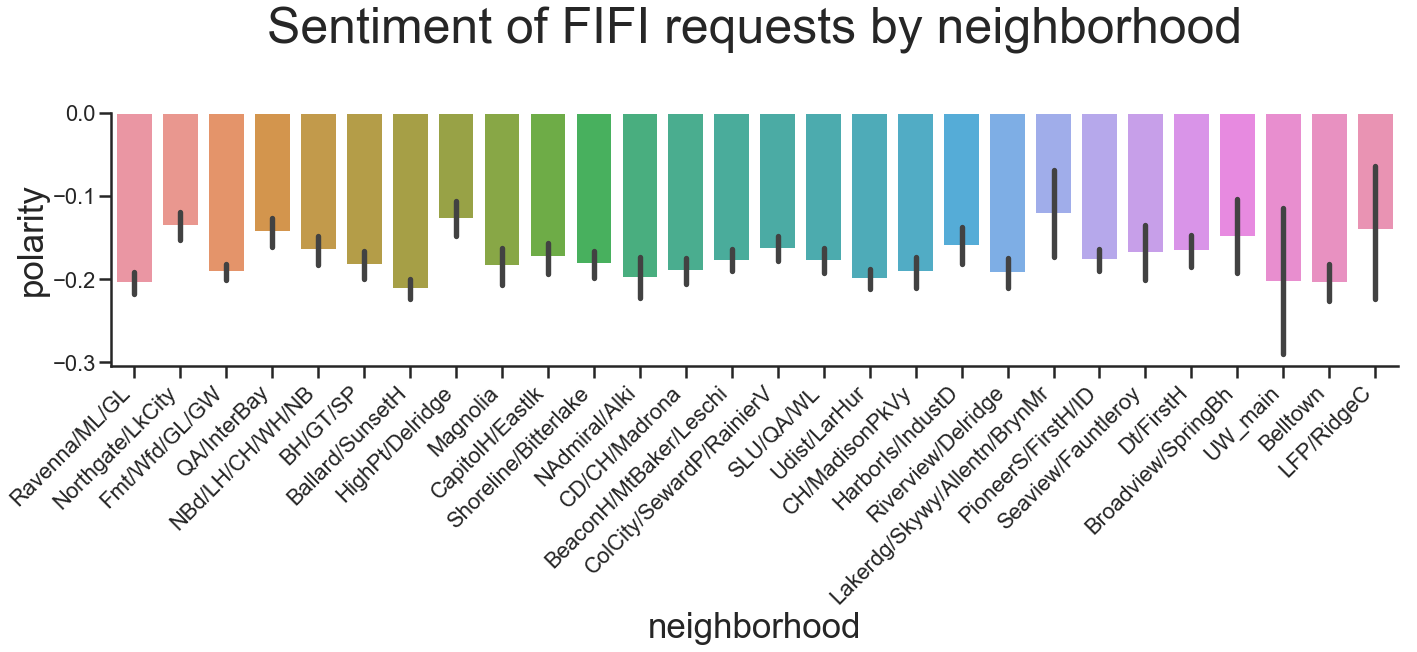

In [65]:
#how does sentiment change across neighborhoods only within the other category?
g = sns.catplot(x='neighborhood', y='polarity', data=data_complete_seattle_other, kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('Sentiment of FIFI requests by neighborhood', y=1.25)
plt.subplots_adjust(hspace = 1.5)

### Word frequency exploration

In [87]:
#combine all text entries grouped by FIFI_category
groupby_FIFI_cat_neigh = data_complete_seattle.groupby(['FIFI_category', 'neighborhood'])['desc_nltk'].sum(axis=1).reset_index(name='words_clean_neigh')
groupby_FIFI_cat_neigh['words_clean_str'] = groupby_FIFI_cat_neigh['words_clean_neigh'].astype(str)

groupby_FIFI_cat = groupby_FIFI_cat_neigh.groupby(['FIFI_category'])['words_clean_neigh'].sum(axis=1).reset_index(name='words_clean')
groupby_FIFI_cat['words_clean_str'] = groupby_FIFI_cat['words_clean'].astype(str)

groupby_FIFI_cat["FIFI_category"]= groupby_FIFI_cat["FIFI_category"].replace({'Needles/Dumping': 'Needles_Dumping',
                                                                              'Sign/Signal': 'Sign_Signal'}) 

print(groupby_FIFI_cat.shape)
groupby_FIFI_cat

(11, 3)


,FIFI_category,words_clean,words_clean_str
0,Abnd_Vehicle,"[semi, tractor, vehicl, park, 4, day, straight...","['semi', 'tractor', 'vehicl', 'park', '4', 'da..."
1,Clogged_Drain,"[new, walkway, flood, slipperi, fallen, leaf, ...","['new', 'walkway', 'flood', 'slipperi', 'falle..."
2,Dead Animal,"[dead, raccoon, north, side, street, pave, par...","['dead', 'raccoon', 'north', 'side', 'street',..."
3,Grafitti,"[graffiti, tag, graffiti, signal, box, next, g...","['graffiti', 'tag', 'graffiti', 'signal', 'box..."
4,Needles_Dumping,"[larg, tv, stand, dump, rv, mattress, overpass...","['larg', 'tv', 'stand', 'dump', 'rv', 'mattres..."
5,Other,"[cdl, recycl, pollut, street, dust, water, car...","['cdl', 'recycl', 'pollut', 'street', 'dust', ..."
6,Parking,"[park, sidewalk, block, public, staircas, park...","['park', 'sidewalk', 'block', 'public', 'stair..."
7,Pothole,"[mani, pothol, 8th, ave, south, 5500, block, l...","['mani', 'pothol', '8th', 'ave', 'south', '550..."
8,Sign_Signal,"[traffic, light, walk, signal, chang, audio, c...","['traffic', 'light', 'walk', 'signal', 'chang'..."
9,Streetlight,"[streetlight, columbia, drive, pearl, power, l...","['streetlight', 'columbia', 'drive', 'pearl', ..."


Abnd_Vehicle


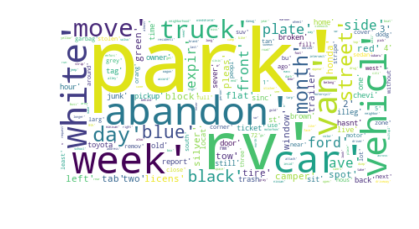

Clogged_Drain


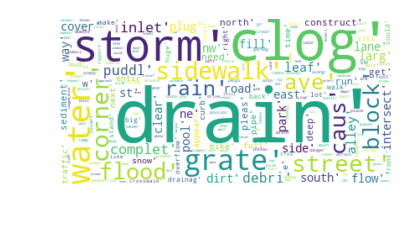

Dead Animal


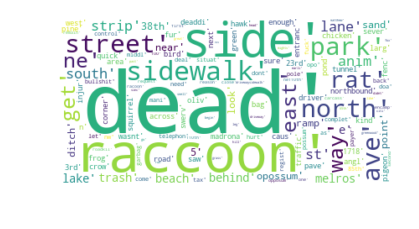

Grafitti


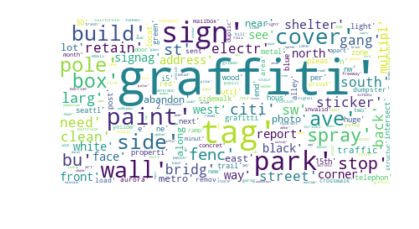

Needles_Dumping


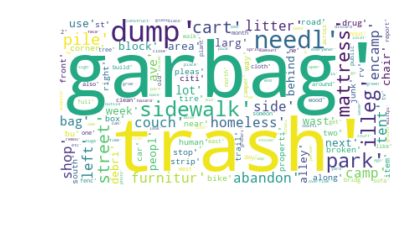

Other


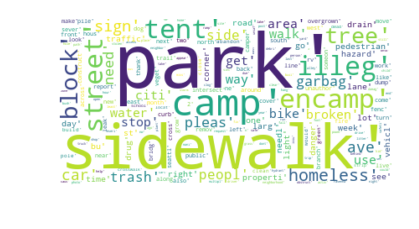

Parking


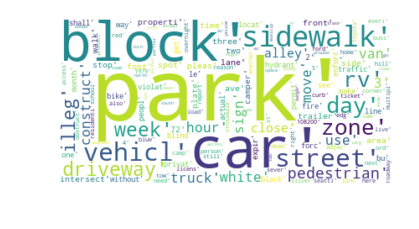

Pothole


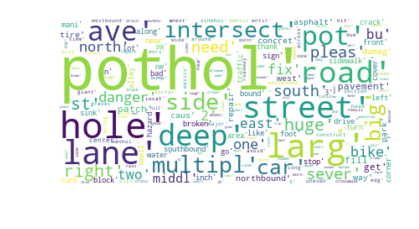

Sign_Signal


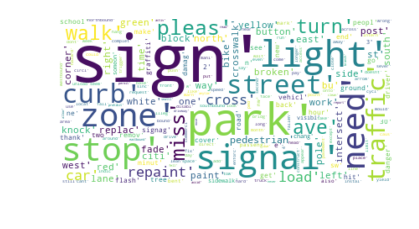

Streetlight


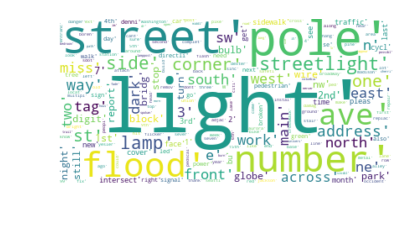

Vegetation


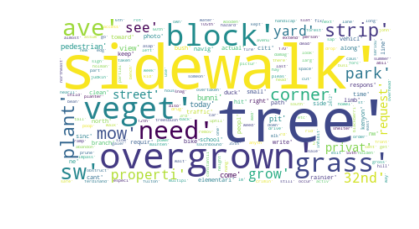

In [88]:
#build a word cloud for each FIFI_cat and neighborhood combo
for index, row in groupby_FIFI_cat.iterrows():
    
    print(row['FIFI_category'])
    
    text = row['words_clean_str']

    wordcloud = WordCloud(collocations=False, background_color="white").generate(text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(str(row['FIFI_category'] + 'FIFIbymonth.png'))
    plt.show()

Abnd_Vehicle
park;7472
rv;3802
abandon;3760
week;3684
car;3600


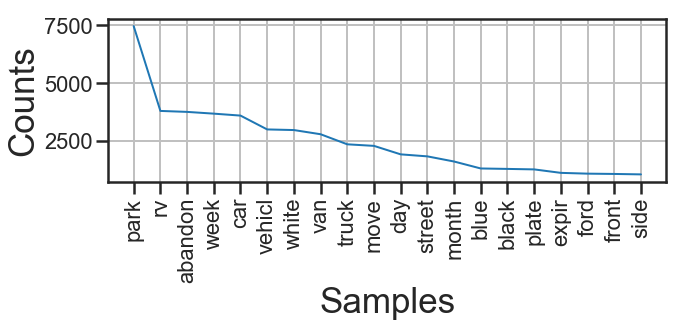

Clogged_Drain
drain;351
clog;292
storm;176
water;95
grate;65


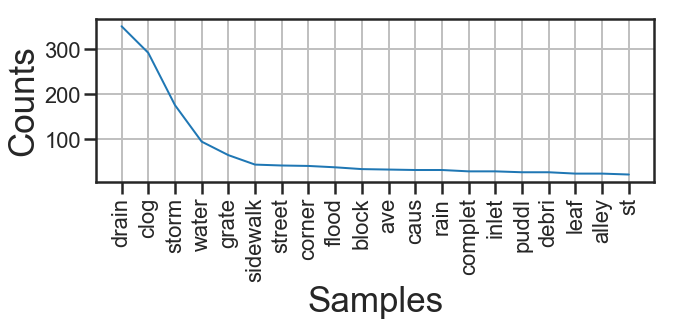

Dead Animal
dead;23
raccoon;10
side;8
sidewalk;7
north;6


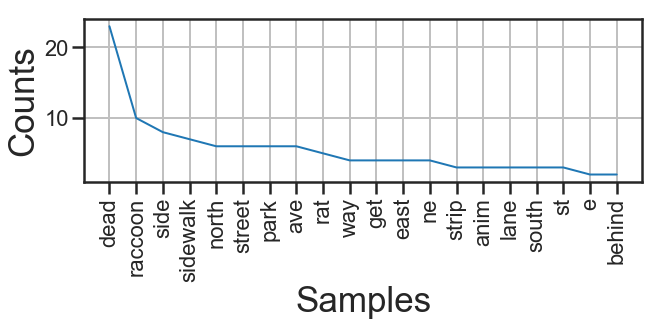

Grafitti
graffiti;10957
tag;3509
sign;2811
park;2333
paint;1893


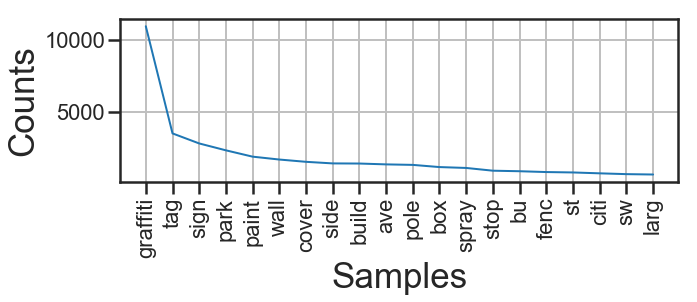

Needles_Dumping
garbag;8296
trash;7787
dump;7217
needl;4758
sidewalk;3429


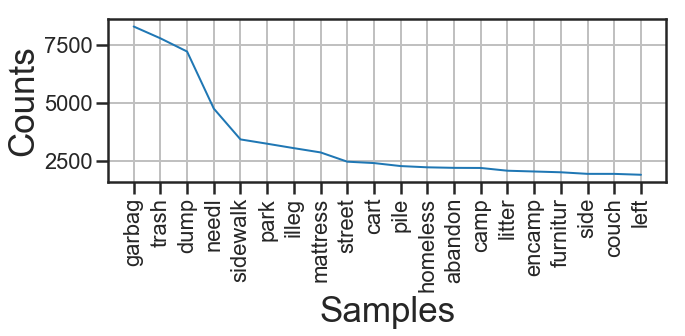

Other
park;8236
sidewalk;7282
camp;6141
encamp;5209
illeg;5100


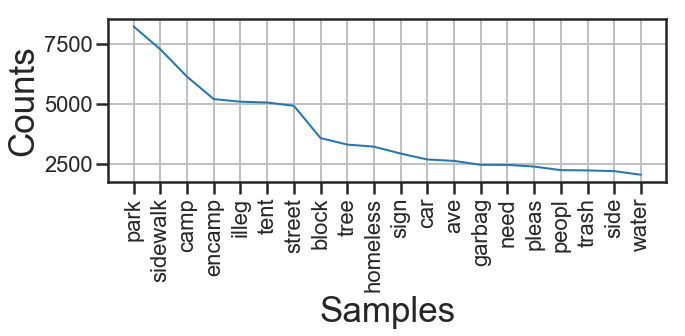

Parking
park;19305
car;5685
block;5340
sidewalk;4842
vehicl;3615


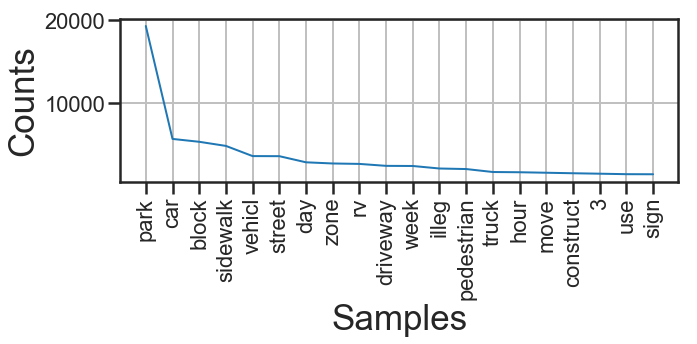

Pothole
pothol;11518
hole;2530
larg;2211
lane;2059
street;1899


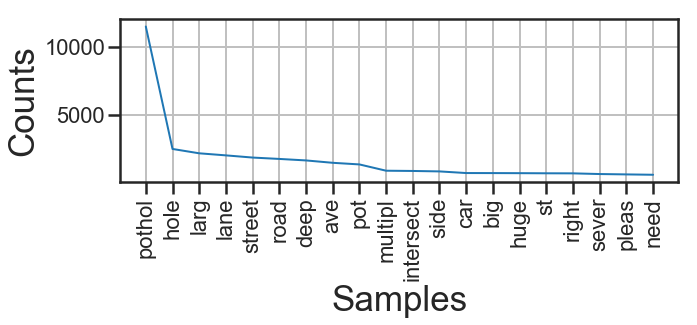

Sign_Signal
sign;7451
park;2538
light;1655
signal;1520
stop;1466


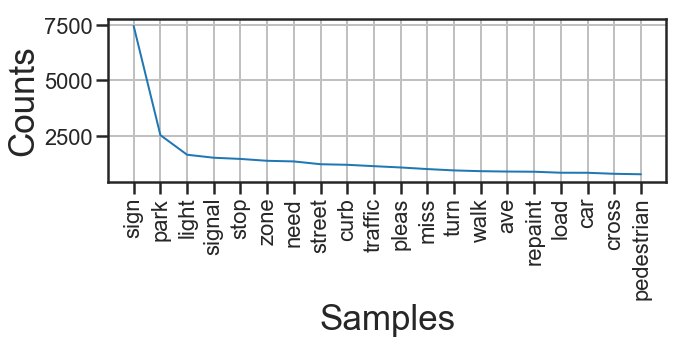

Streetlight
light;4240
pole;1922
street;1743
number;1163
flood;976


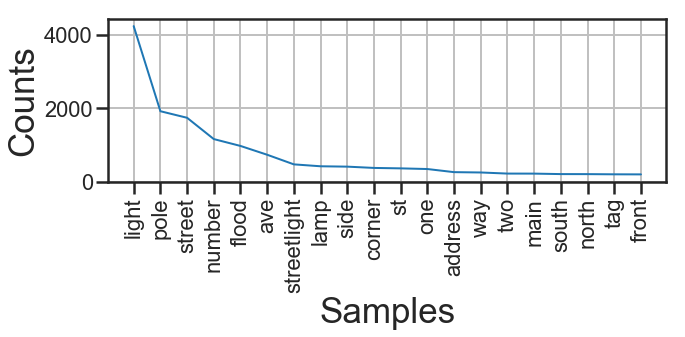

Vegetation
sidewalk;19
tree;18
overgrown;18
veget;14
block;13


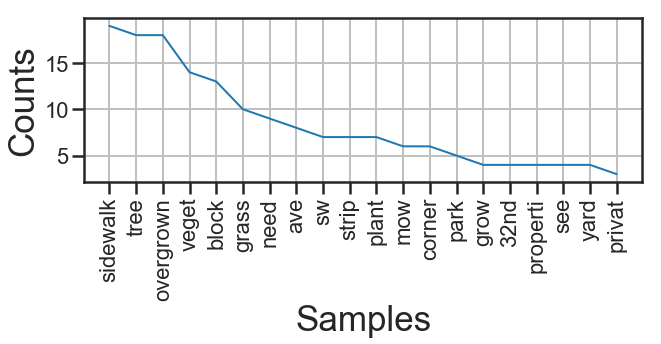

In [89]:
#find top 5 used words for each FIFI_cat
for index, row in groupby_FIFI_cat.iterrows():
    
    print(row['FIFI_category'])
    
    fdist = FreqDist(row['words_clean'])
    
    #print top 5
    for word, frequency in fdist.most_common(5):
        print(u'{};{}'.format(word, frequency))

    #sns.distplot(fdist)
    plt.figure(figsize=(10,3))
    fdist.plot(20,cumulative=False)
    plt.show()

### POS analysis

In [126]:
#use groupby and sum to get a combined list containing POS tagging data
pos_FIFIcat_groupby = data_complete_seattle.groupby(['FIFI_category', 'neighborhood'])['POS'].sum(axis=1).reset_index(name='POS')
#use counter to count POS for each groupby category 
pos_FIFIcat_groupby['POS_count'] = [Counter(tag for word, tag in row) for row in pos_FIFIcat_groupby['POS']]
print(pos_FIFIcat_groupby.shape)
print(pos_FIFIcat_groupby.info())
pos_FIFIcat_groupby.head(1)

(143, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 4 columns):
FIFI_category    143 non-null object
neighborhood     143 non-null object
POS              143 non-null object
POS_count        143 non-null object
dtypes: object(4)
memory usage: 4.5+ KB
None


,FIFI_category,neighborhood,POS,POS_count
0,Abnd_Vehicle,Ballard,"[(larg, NN), (southwind, NN), (brand, NN), (rv...","{'NN': 20507, 'JJ': 6184, 'IN': 605, 'VBD': 47..."


Other
Ballard
Counter({'NN': 34641, 'JJ': 9798, 'VBP': 2339, 'CD': 2323, 'RB': 1801, 'IN': 1504, 'VB': 1112, 'VBD': 1073, 'NNS': 1039, 'VBN': 790, 'VBZ': 347, 'MD': 261, 'JJS': 153, 'FW': 113, 'JJR': 109, 'DT': 89, 'CC': 82, 'RBR': 59, 'VBG': 33, 'NNP': 32, 'RP': 31, '$': 31, 'PRP': 20, 'WDT': 16, 'EX': 13, 'WP': 11, 'WRB': 5, 'RBS': 4, 'PRP$': 3, 'WP$': 3, 'TO': 1})


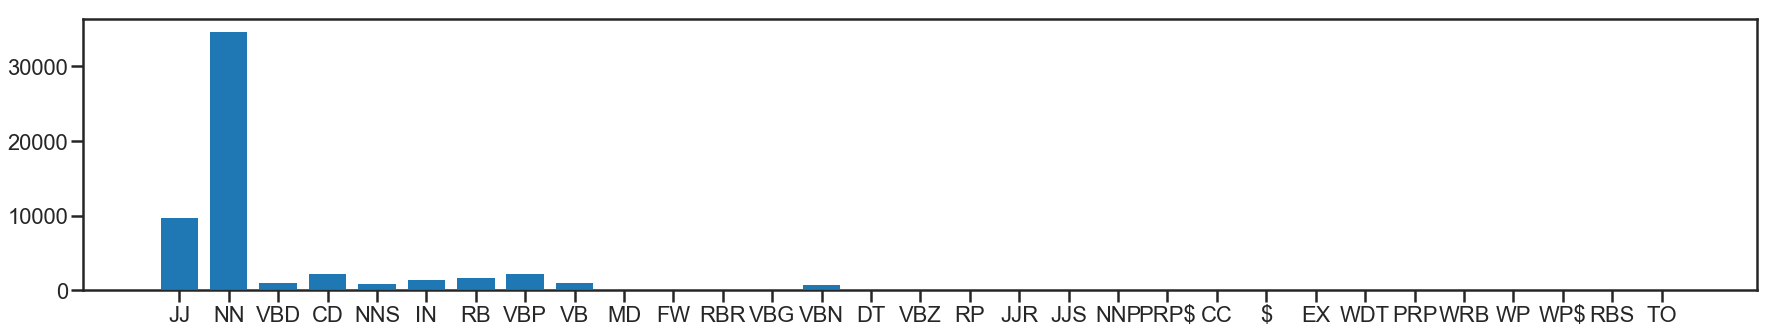

Other
Bitterlake
Counter({'NN': 10471, 'JJ': 2908, 'VBP': 713, 'CD': 701, 'RB': 542, 'IN': 441, 'VB': 353, 'VBD': 299, 'NNS': 296, 'VBN': 202, 'VBZ': 95, 'MD': 72, 'JJR': 48, 'JJS': 40, 'FW': 34, 'DT': 29, 'CC': 24, 'RBR': 21, '$': 11, 'RP': 11, 'VBG': 10, 'NNP': 4, 'WRB': 3, 'PRP': 3, 'EX': 3, 'WP': 3, 'WDT': 3, 'PRP$': 2, 'RBS': 2, 'TO': 1})


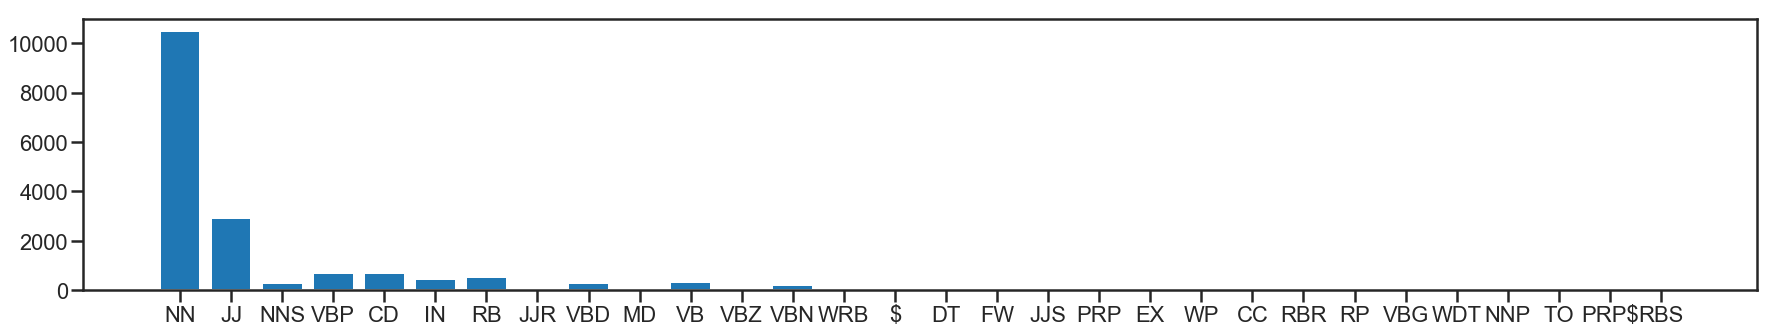

Other
Cap_Hill
Counter({'NN': 7334, 'JJ': 1986, 'VBP': 524, 'CD': 403, 'RB': 312, 'IN': 284, 'VB': 270, 'VBD': 226, 'NNS': 213, 'VBN': 125, 'MD': 71, 'VBZ': 41, 'JJS': 29, 'RP': 18, 'JJR': 17, 'DT': 14, 'RBR': 14, 'CC': 13, 'FW': 13, '$': 10, 'NNP': 10, 'WP': 6, 'VBG': 4, 'PRP': 2, 'WP$': 1, 'PRP$': 1, 'WRB': 1})


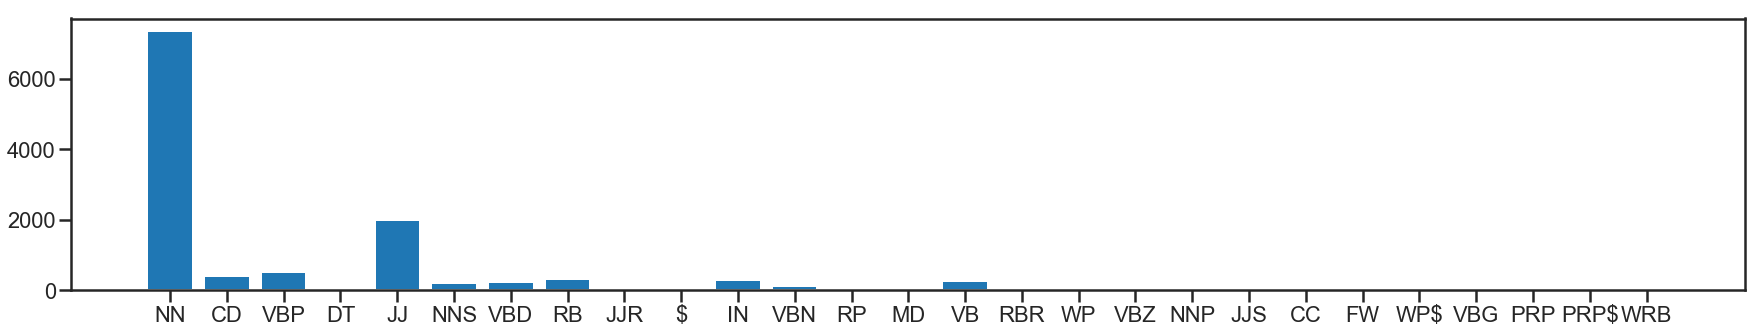

Other
ColCity/SewardP
Counter({'NN': 11738, 'JJ': 3268, 'VBP': 973, 'RB': 629, 'CD': 580, 'IN': 505, 'VBD': 488, 'VB': 454, 'NNS': 381, 'VBN': 276, 'MD': 112, 'VBZ': 101, 'JJR': 95, 'JJS': 51, 'RP': 46, 'DT': 30, 'FW': 29, 'VBG': 18, 'CC': 17, 'RBR': 16, '$': 15, 'PRP': 10, 'NNP': 10, 'EX': 8, 'WP': 4, 'WDT': 3, 'RBS': 3, 'PRP$': 2, 'WRB': 1, 'PDT': 1})


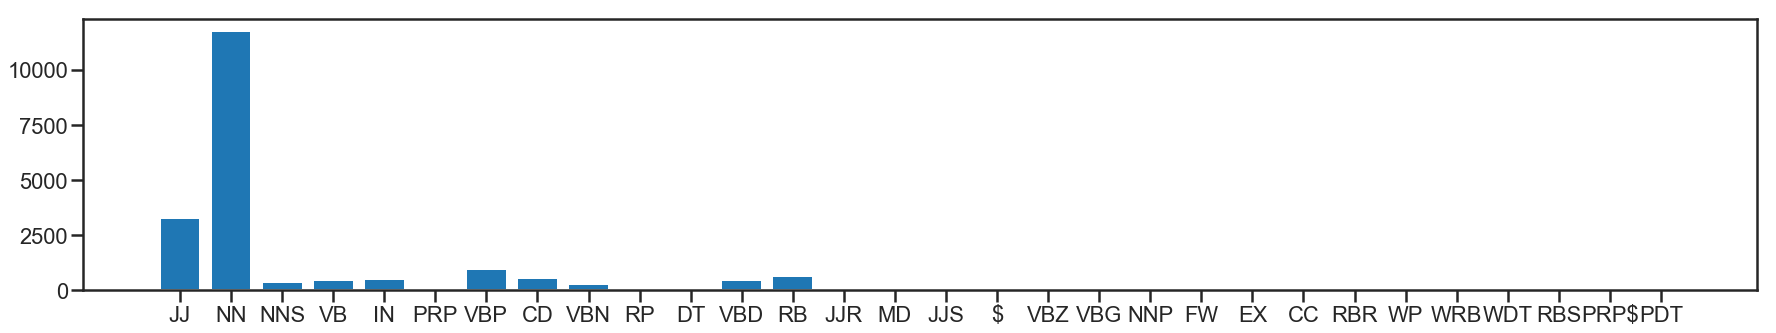

Other
Delridge
Counter({'NN': 30824, 'JJ': 8668, 'VBP': 2030, 'CD': 1880, 'RB': 1528, 'IN': 1398, 'VBD': 994, 'VB': 854, 'NNS': 756, 'VBN': 620, 'JJS': 274, 'MD': 234, 'VBZ': 182, 'JJR': 94, 'FW': 66, 'RP': 62, 'NNP': 54, 'RBR': 48, 'DT': 44, 'CC': 34, 'VBG': 20, '$': 16, 'WRB': 14, 'PRP': 12, 'EX': 8, 'RBS': 6, 'WP': 4, 'WDT': 4, 'TO': 2})


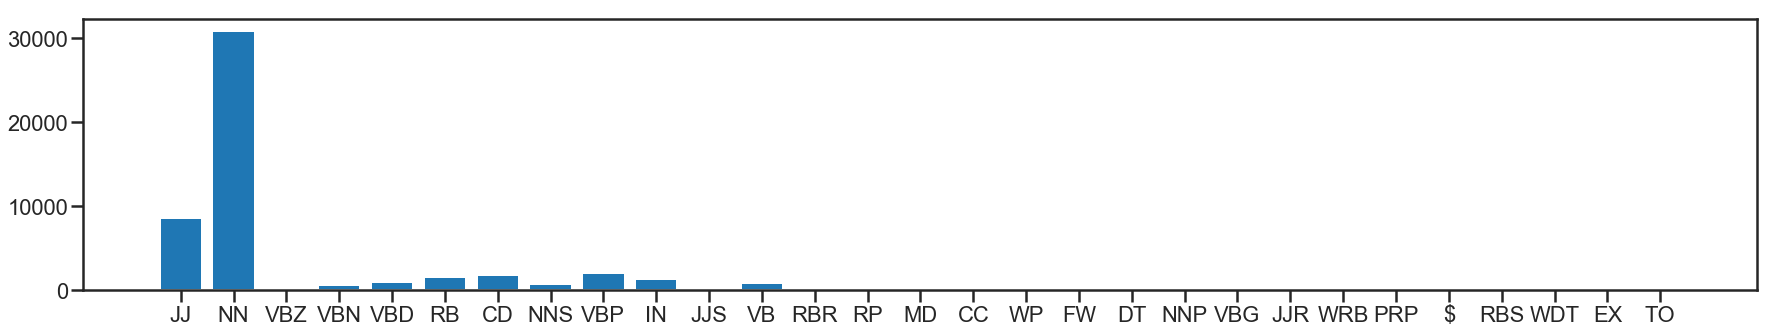

Other
GnWd/Frmt/GnLk
Counter({'NN': 26622, 'JJ': 7330, 'VBP': 1830, 'CD': 1752, 'RB': 1351, 'IN': 1160, 'VB': 819, 'VBD': 818, 'NNS': 739, 'VBN': 553, 'VBZ': 249, 'MD': 228, 'JJS': 155, 'JJR': 93, 'DT': 85, 'RBR': 69, 'FW': 58, 'CC': 56, 'RP': 44, 'VBG': 30, 'NNP': 24, '$': 22, 'PRP': 15, 'WP': 11, 'WDT': 10, 'EX': 5, 'WRB': 4, 'RBS': 4, 'PRP$': 3, 'TO': 1})


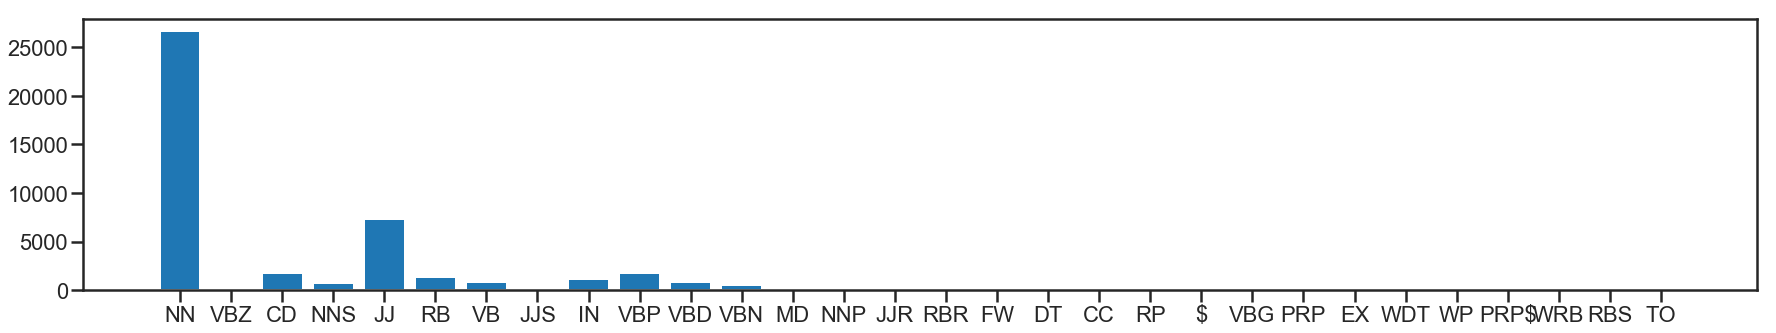

Other
Leschi
Counter({'NN': 12563, 'JJ': 3294, 'VBP': 814, 'CD': 757, 'RB': 593, 'IN': 507, 'VBD': 475, 'VB': 415, 'NNS': 313, 'VBN': 230, 'MD': 108, 'VBZ': 100, 'JJR': 73, 'JJS': 66, 'FW': 39, 'DT': 35, 'RP': 25, 'NNP': 19, 'RBR': 18, 'CC': 15, 'VBG': 9, 'WP': 7, 'PRP': 5, 'WRB': 4, 'WDT': 4, 'EX': 3, 'RBS': 3, '$': 2, 'PRP$': 2, 'POS': 1})


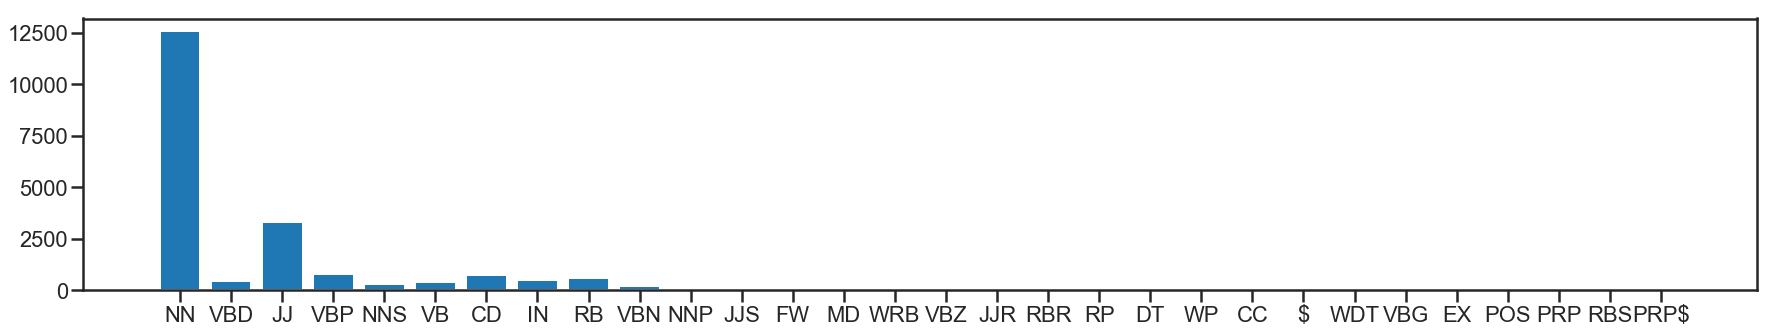

Other
Madison_Park
Counter({'NN': 9174, 'JJ': 2534, 'CD': 695, 'VBP': 672, 'RB': 459, 'IN': 341, 'VB': 331, 'VBD': 324, 'NNS': 287, 'VBN': 201, 'MD': 93, 'VBZ': 81, 'JJS': 41, 'JJR': 34, 'FW': 24, 'DT': 14, 'RP': 14, 'RBR': 13, 'CC': 13, 'NNP': 10, 'VBG': 9, '$': 7, 'EX': 5, 'WP': 3, 'PRP': 2, 'WRB': 1, 'WDT': 1})


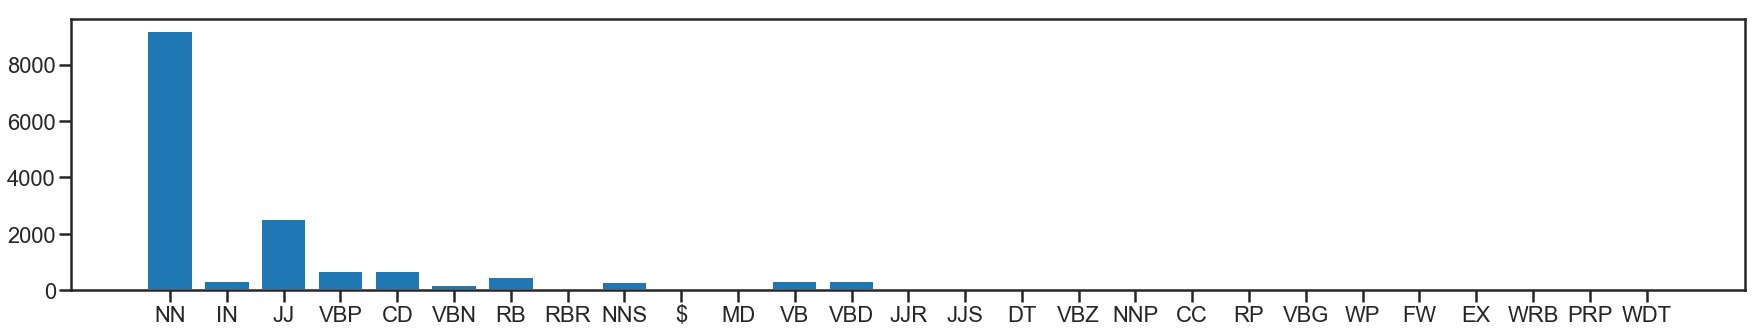

Other
Magnolia
Counter({'NN': 5588, 'JJ': 1504, 'VBP': 425, 'CD': 337, 'RB': 241, 'IN': 233, 'NNS': 206, 'VB': 177, 'VBD': 176, 'VBN': 122, 'MD': 60, 'VBZ': 42, 'JJS': 32, 'FW': 20, 'JJR': 19, 'RP': 15, 'VBG': 14, 'DT': 11, 'NNP': 6, 'RBR': 6, 'CC': 3, 'WDT': 3, 'EX': 3, '$': 2, 'WRB': 2, 'PDT': 1, 'WP': 1})


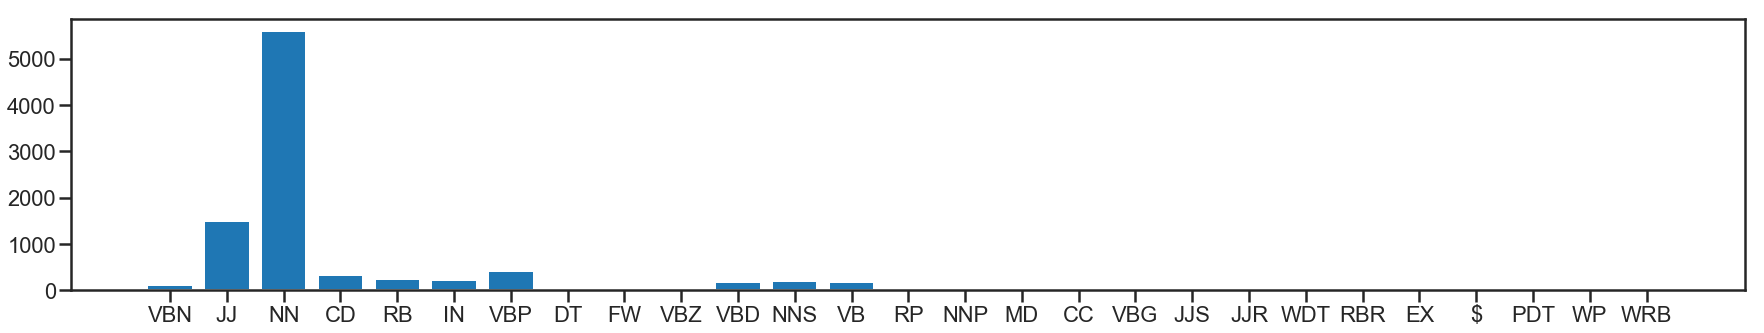

Other
MtBaker
Counter({'NN': 15448, 'JJ': 4084, 'VBP': 1091, 'CD': 787, 'RB': 744, 'IN': 676, 'VB': 528, 'VBD': 479, 'NNS': 413, 'VBN': 335, 'MD': 138, 'VBZ': 111, 'JJR': 71, 'JJS': 67, 'RBR': 28, 'FW': 27, 'RP': 26, 'CC': 24, 'DT': 23, 'NNP': 19, 'VBG': 14, '$': 7, 'WP': 7, 'EX': 7, 'PRP': 6, 'WRB': 5, 'PRP$': 2, 'WDT': 2, 'RBS': 1})


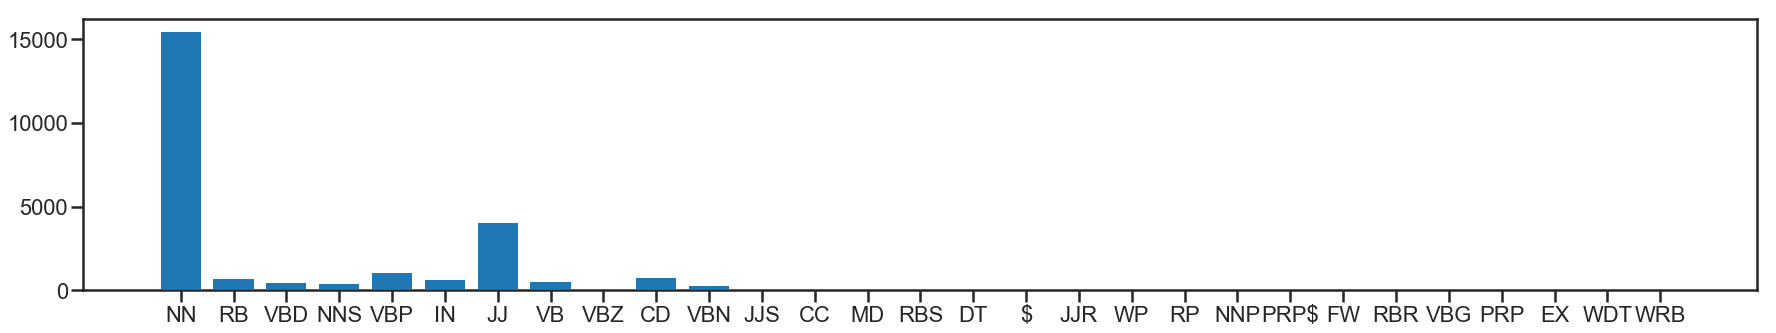

Other
Northgate
Counter({'NN': 10211, 'JJ': 2900, 'VBP': 741, 'CD': 720, 'RB': 558, 'IN': 471, 'VB': 362, 'NNS': 335, 'VBD': 333, 'VBN': 202, 'MD': 105, 'VBZ': 98, 'JJS': 46, 'JJR': 38, 'CC': 33, 'RP': 22, 'RBR': 20, 'FW': 17, 'DT': 16, '$': 9, 'WP': 8, 'VBG': 4, 'NNP': 4, 'EX': 2, 'RBS': 1, 'PRP': 1})


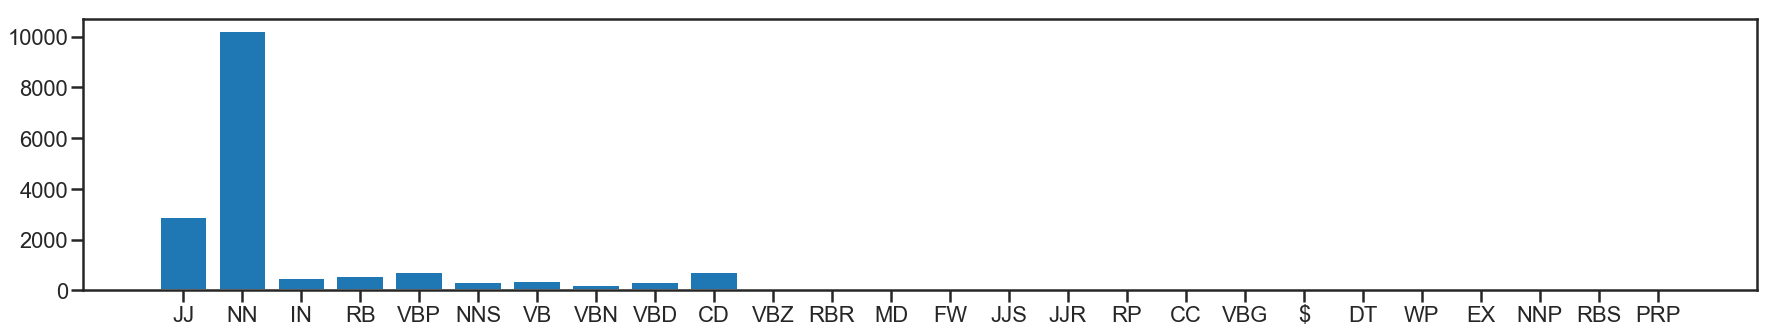

Other
PioneerS/FirstH
Counter({'NN': 11767, 'JJ': 3098, 'VBP': 760, 'CD': 653, 'RB': 498, 'IN': 414, 'NNS': 357, 'VB': 353, 'VBD': 343, 'VBN': 182, 'VBZ': 92, 'MD': 76, 'JJR': 36, 'JJS': 35, 'VBG': 30, 'FW': 30, 'DT': 26, 'CC': 22, 'RBR': 19, 'RP': 19, 'NNP': 15, '$': 7, 'EX': 6, 'PRP': 5, 'WP': 5, 'PRP$': 3, 'WDT': 2, 'RBS': 2, 'UH': 1})


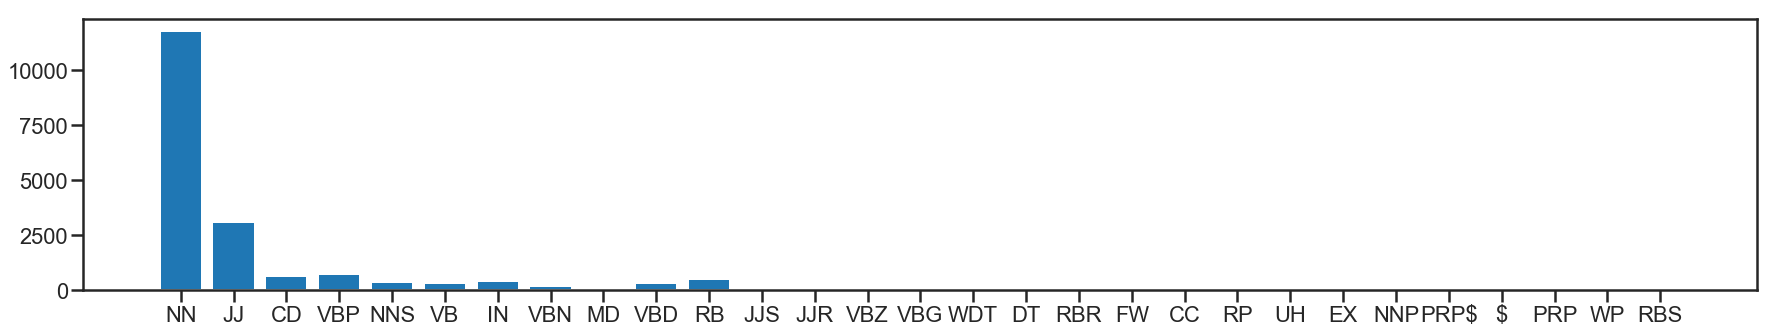

Other
Queen_Anne
Counter({'NN': 9720, 'JJ': 2627, 'CD': 744, 'VBP': 662, 'RB': 459, 'IN': 402, 'VB': 334, 'VBD': 316, 'NNS': 247, 'VBN': 194, 'VBZ': 78, 'MD': 74, 'JJR': 59, 'JJS': 54, 'RBR': 38, 'DT': 22, 'FW': 22, 'CC': 21, 'RP': 18, 'VBG': 16, 'EX': 10, 'NNP': 10, '$': 5, 'WRB': 4, 'WDT': 3, 'WP': 2, 'PRP$': 2, 'PRP': 1, 'RBS': 1, 'UH': 1})


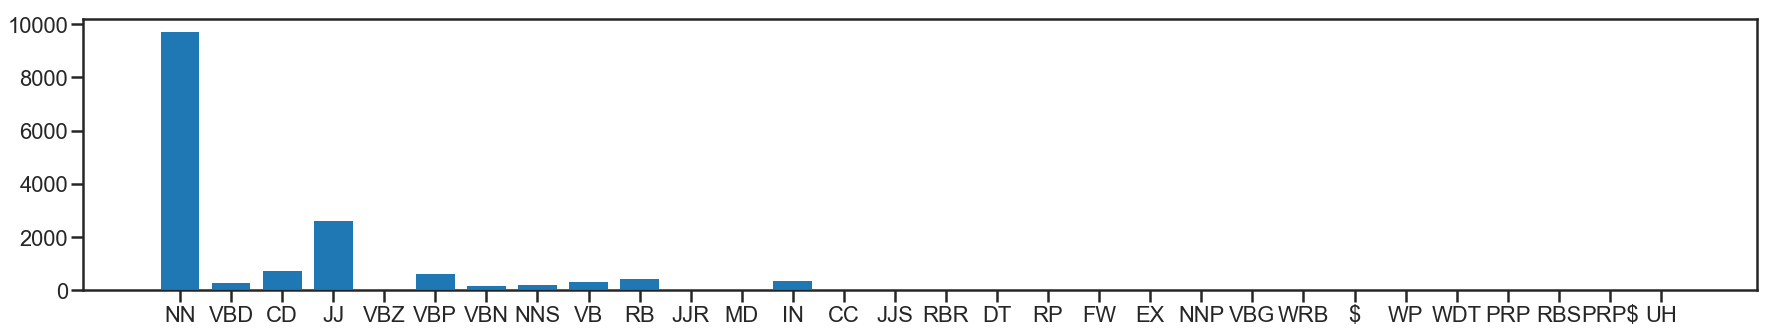

Other
South_Park
Counter({'NN': 9733, 'JJ': 2550, 'VBP': 616, 'CD': 497, 'RB': 419, 'IN': 382, 'NNS': 309, 'VBD': 307, 'VB': 294, 'VBN': 177, 'VBZ': 75, 'MD': 74, 'FW': 40, 'JJS': 33, 'JJR': 23, 'RP': 23, 'DT': 16, 'CC': 14, 'RBR': 13, 'VBG': 9, 'EX': 8, 'PRP': 5, 'WP': 4, 'NNP': 3, '$': 3, 'WRB': 2, 'WDT': 2, 'LS': 1, 'PRP$': 1, 'WP$': 1})


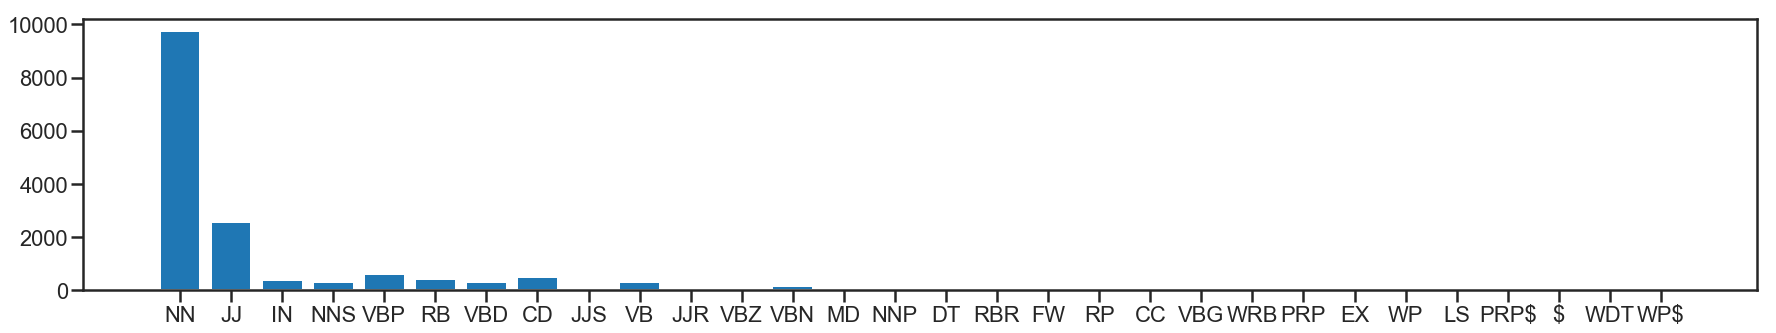

Other
Udist/LarHur
Counter({'NN': 18289, 'JJ': 5039, 'CD': 1330, 'VBP': 1286, 'RB': 902, 'IN': 823, 'NNS': 613, 'VB': 546, 'VBD': 542, 'VBN': 345, 'VBZ': 185, 'MD': 149, 'JJS': 91, 'JJR': 50, 'FW': 44, 'CC': 36, 'DT': 35, 'RBR': 32, 'RP': 31, 'VBG': 17, 'NNP': 17, '$': 16, 'PRP': 8, 'EX': 6, 'PRP$': 6, 'RBS': 5, 'WP': 5, 'WDT': 4, 'WRB': 1, 'TO': 1})


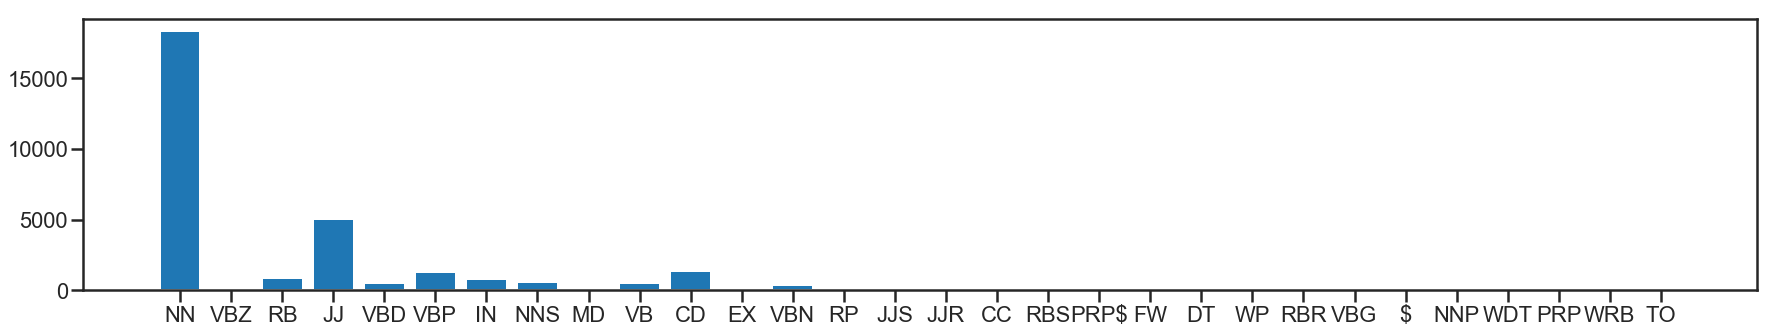

Other
WA
Counter({'NN': 56676, 'JJ': 16105, 'VBP': 4506, 'CD': 4371, 'RB': 2975, 'IN': 2256, 'VB': 2078, 'VBD': 2046, 'NNS': 1874, 'VBN': 1180, 'MD': 571, 'VBZ': 463, 'JJS': 304, 'JJR': 209, 'DT': 125, 'CC': 111, 'RP': 108, 'FW': 107, 'RBR': 93, 'NNP': 53, 'VBG': 53, '$': 44, 'EX': 34, 'WP': 26, 'PRP': 24, 'WRB': 19, 'WDT': 17, 'PRP$': 8, 'RBS': 6, 'WP$': 5, 'LS': 1, 'POS': 1, "''": 1, 'UH': 1})


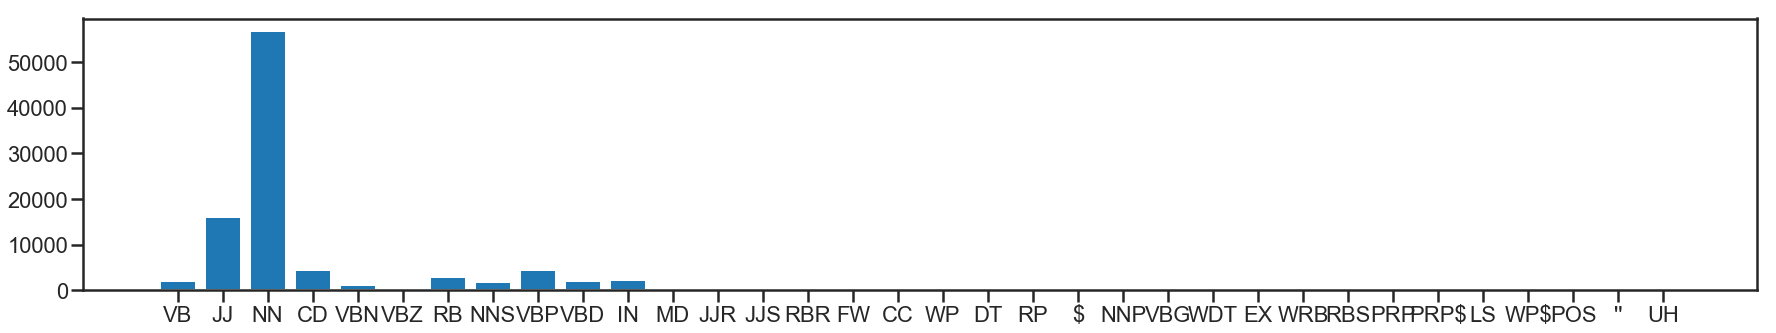

Other
Wedgewood
Counter({'NN': 14724, 'JJ': 4007, 'CD': 1045, 'VBP': 958, 'RB': 785, 'IN': 652, 'VB': 481, 'VBD': 480, 'NNS': 391, 'VBN': 280, 'VBZ': 132, 'MD': 113, 'JJS': 56, 'JJR': 56, 'FW': 35, 'CC': 27, 'RP': 27, 'DT': 27, 'RBR': 24, 'NNP': 11, '$': 11, 'PRP': 8, 'WRB': 7, 'VBG': 6, 'EX': 6, 'WP': 4, 'PRP$': 3, 'RBS': 2, 'WP$': 2})


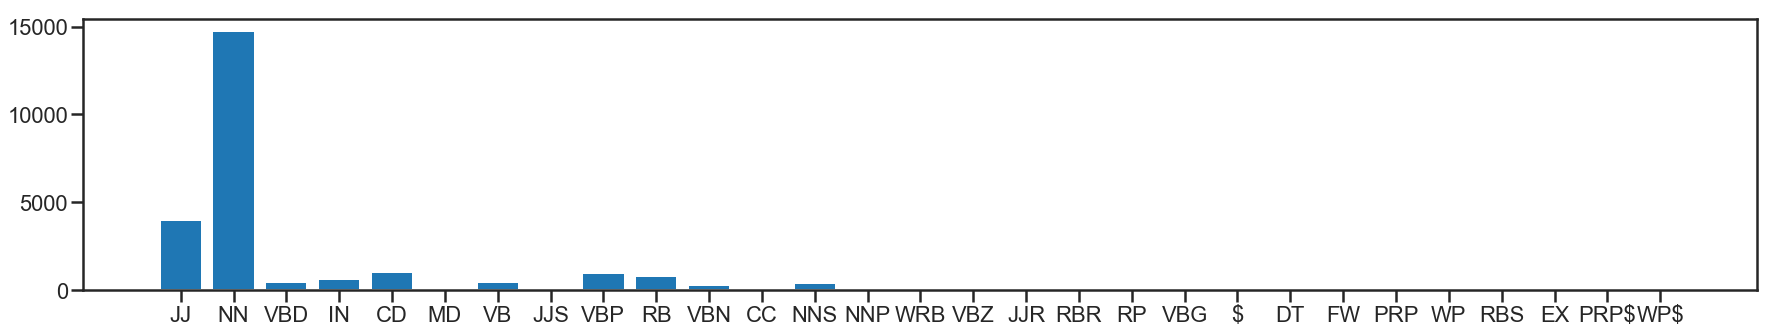

Other
Westlake
Counter({'NN': 12913, 'JJ': 3707, 'VBP': 982, 'CD': 721, 'RB': 691, 'VB': 560, 'IN': 526, 'VBD': 455, 'NNS': 449, 'VBN': 251, 'MD': 143, 'VBZ': 107, 'JJS': 70, 'JJR': 47, 'DT': 36, 'RP': 29, 'FW': 29, 'CC': 25, 'NNP': 20, 'RBR': 20, 'VBG': 10, '$': 4, 'PRP': 4, 'EX': 4, 'WP': 3, 'RBS': 2, 'PRP$': 2, 'WP$': 1, 'WDT': 1})


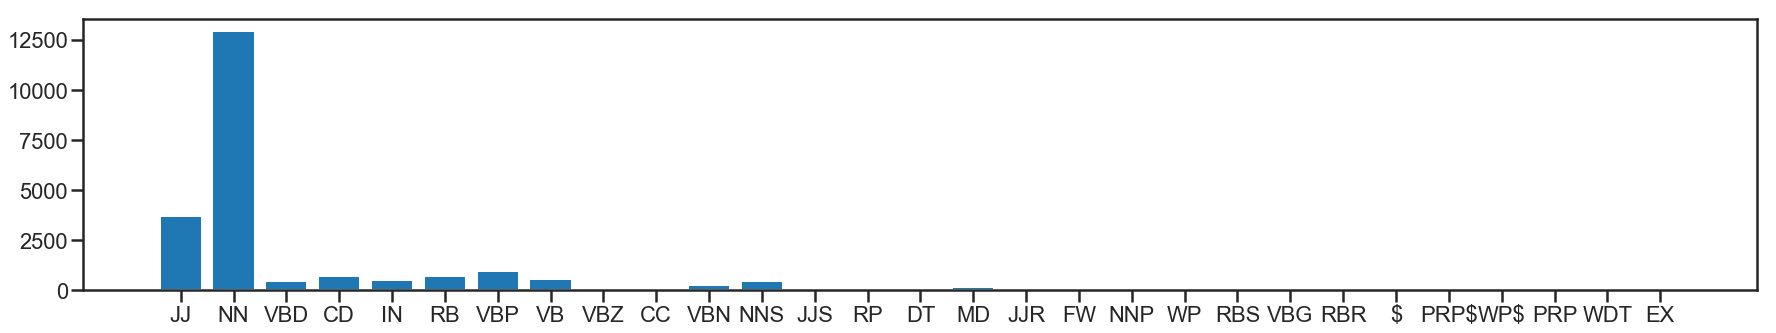

In [195]:
other_POS_groupby = pos_FIFIcat_groupby[pos_FIFIcat_groupby['FIFI_category'] == 'Other']
#find top 5 used words for each FIFI_cat and neighborhood combo
for index, row in other_POS_groupby.iterrows():
    
    print(row['FIFI_category'])
    print(row['neighborhood'])

    data = row['POS_count']
    print(data)
    plt.figure(figsize=(30,5))
    plt.bar(data.keys(), data.values())
    plt.show()

### Topic modeling with LDA

In [101]:
#Find single topic for each category

categories = data['FIFI_category'].unique()

for cat in categories:
    
    print(cat)
    
    data_desc = data_complete_seattle[data_complete_seattle['FIFI_category'] == cat]['desc_nltk'].values
    
    # Create dictionary
    dictionary = corpora.Dictionary(data_desc)
    #print(dictionary)

    #filter dictionary
    #dictionary.filter_extremes(no_below=5, no_above=0.1)

    #create corpus
    bow_corpus = [dictionary.doc2bow(doc) for doc in data_desc]

    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 1, 
                                   id2word = dictionary)

    for idx, topic in lda_model.print_topics(-1):
        print("Words: {}".format(topic ))
        print("\n")

Abnd_Vehicle
Words: 0.041*"park" + 0.022*"car" + 0.021*"week" + 0.021*"abandon" + 0.017*"rv" + 0.017*"vehicl" + 0.016*"white" + 0.014*"move" + 0.014*"van" + 0.013*"truck"


Grafitti
Words: 0.100*"graffiti" + 0.032*"tag" + 0.026*"sign" + 0.021*"park" + 0.017*"paint" + 0.016*"wall" + 0.014*"cover" + 0.013*"side" + 0.013*"build" + 0.012*"ave"


Needles/Dumping
Words: 0.032*"garbag" + 0.030*"trash" + 0.027*"dump" + 0.018*"needl" + 0.013*"sidewalk" + 0.012*"park" + 0.012*"illeg" + 0.011*"mattress" + 0.009*"street" + 0.009*"homeless"


Parking
Words: 0.069*"park" + 0.030*"sidewalk" + 0.022*"car" + 0.021*"block" + 0.017*"street" + 0.016*"pedestrian" + 0.013*"vehicl" + 0.011*"construct" + 0.010*"zone" + 0.010*"use"


Pothole
Words: 0.091*"pothol" + 0.021*"hole" + 0.018*"lane" + 0.018*"larg" + 0.013*"street" + 0.013*"road" + 0.013*"pot" + 0.012*"ave" + 0.012*"deep" + 0.009*"intersect"


Streetlight
Words: 0.095*"light" + 0.043*"pole" + 0.039*"street" + 0.026*"number" + 0.022*"flood" + 0.017*"av

In [104]:
#other data 
other = data[data['FIFI_category'] == 'Other']

# Create dictionary
dictionary = corpora.Dictionary(other['desc_nltk'].values)
print(dictionary)

#filter dictionary
#dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in other['desc_nltk']]

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Dictionary(17657 unique tokens: ['come', 'downtown', 'get', 'inform', 'liquefact']...)
Topic: 0 
Words: 0.027*"encamp" + 0.027*"park" + 0.023*"camp" + 0.022*"illeg" + 0.021*"tent" + 0.013*"tree" + 0.012*"sidewalk" + 0.012*"homeless" + 0.009*"broken" + 0.008*"sign"


Topic: 1 
Words: 0.027*"sidewalk" + 0.013*"block" + 0.010*"bike" + 0.010*"lane" + 0.009*"camp" + 0.009*"traffic" + 0.008*"park" + 0.007*"car" + 0.007*"illeg" + 0.007*"sign"


Topic: 2 
Words: 0.023*"street" + 0.015*"park" + 0.010*"garbag" + 0.010*"ave" + 0.010*"trash" + 0.009*"sidewalk" + 0.009*"water" + 0.008*"car" + 0.008*"sign" + 0.006*"walk"




In [13]:
#other data dividied by sentiment score
other = data[data['FIFI_category'] == 'Other']
other_pos = other[other['polarity'] > 0.5]
other_neg = other[other['polarity'] < -0.5]

print('Other category requests with polairty > 0.5')
# Create dictionary
dictionary = corpora.Dictionary(other_pos['desc_nltk'].values)
print(dictionary)

#filter dictionary
#dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in other_pos['desc_nltk']]

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 1, 
                                   id2word = dictionary)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

    
print('Other category requests with polairty < -0.5')
# Create dictionary
dictionary = corpora.Dictionary(other_neg['desc_nltk'].values)
print(dictionary)

#filter dictionary
#dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in other_neg['desc_nltk']]

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 1, 
                                   id2word = dictionary)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Other category requests with polairty > 0.5
Dictionary(5407 unique tokens: ['dog', 'love', 'market', 'park', 'see']...)
Topic: 0 
Words: 0.015*"pleas" + 0.012*"park" + 0.010*"thank" + 0.008*"street" + 0.006*"sidewalk" + 0.006*"ave" + 0.006*"citi" + 0.005*"area" + 0.005*"car" + 0.005*"need"


Other category requests with polairty < -0.5
Dictionary(8644 unique tokens: ['alleyway', 'dump', 'illeg', 'area', 'creat']...)
Topic: 0 
Words: 0.029*"illeg" + 0.017*"camp" + 0.017*"park" + 0.011*"encamp" + 0.011*"sidewalk" + 0.010*"block" + 0.009*"street" + 0.008*"sign" + 0.008*"tent" + 0.007*"car"


